## ДЗ Неделя 3


    Решите задачу из прошлой недели методом тяжёлого шарика и ускоренным градиентным методом. 
    
    Сравните сходимость этих методов и градиентного спуска. 

    Нарисуйте один график с тремя линиями, который показывал бы такое сравнение.

    Прокомментируйте результат.

    Проанализируйте влияние параметров методов на их сходимость.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 5000
EPSILON = 0.001
LAMBDA = 50
y = np.hstack([np.ones(1000) + 0.1 * np.random.randn(1000),
               5 * np.ones(1000) + 0.1 *np.random.randn(1000),
               -3*np.ones(1000) + 0.1 *np.random.randn(1000),
               -2 * np.ones(1000) + 0.1 *np.random.randn(1000),
               3 * np.ones(1000) + 0.1 *np.random.randn(1000)])
#plt.plot(y)

#### Стартовую точку не меняем для чистоты эксперимента

In [2]:
np.random.seed(51)
x0 = np.random.randn(n)

#  GD c alpha=const

In [3]:
def f(x):
    return np.sum((x-y)**2) + LAMBDA*(np.sum( np.sqrt( (EPSILON**2)+(np.delete(x,0) - np.delete(x,-1))**2 ) - EPSILON ))


def grad(x):
    # Cоставляем основное тело градиента (краевые точки будут неверными , их далее исправим)
    result = LAMBDA*( (x-np.roll(x,1)) / np.sqrt( EPSILON**2+(x-np.roll(x,1))**2 )
                    +  (x-np.roll(x,-1)) /np.sqrt( EPSILON**2+(np.roll(x,-1)-x)**2 )  )
    
    result = np.delete(result,0)#Удаляем первую компоненту и на ее место вставялем правильное значение
    result = np.insert(result , 0, LAMBDA*((x[0]-x[1])/ np.sqrt(EPSILON**2+(x[1]-x[0])**2 ) ) )
    
    result = np.delete(result , -1)#Удаляем последнюю компоненту и на ее место вставялем правильное значение
    result = np.append(result, LAMBDA*((x[-1]-x[-2])/ np.sqrt(EPSILON**2+(x[-1]-x[-2])**2 ) ) )
    
    result = result + 2*(x-y) #В конце к заготовке прибавляем производую второй нормы(ко всем компонентам)
    
    return result       


def gradient_descent(grad, x0, maxiter, tol, alpha):
    x = x0.copy()
    conv = [x0.copy()]
    for i in range(maxiter):
        g = grad(x)
        if np.linalg.norm(g) < tol:
            break
        x = x - alpha * g
        conv.append(x.copy())
    return x, conv

#### GD 

In [4]:
tol = 1e-5 
max_iter = 10000
alpha = 0.000003
x1_gd, x1_conv_gd = gradient_descent(grad, x0, max_iter, tol, alpha)
print('Решение: {}'.format(x1_gd))
print('Кол-во итераций: {}'.format(len(x1_conv_gd)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(x1_gd)) ) )

Решение: [-0.03461971 -0.03471831 -0.03492381 ... -0.06807468 -0.06865194
 -0.06891109]
Кол-во итераций: 10000
Длина градиента в последней точке алгоритма : 1000.56371156048


## Heavy Ball c alpha=const , beta=const

In [5]:
def heavy_ball(grad, x0, maxiter, tol, alpha , beta):
    x = x0.copy()
    conv = [x0.copy()]
    grad_norm = []
    for i in range(maxiter):
        g = grad(x)
        grad_norm.append( np.linalg.norm(g) )
        if i == 0:
            x_old = x    
            x = x - alpha * g
            
        if i != 0:
            if np.linalg.norm(g) < tol:
                break
            heavy_ball = beta*(x-x_old)
            x_old = x
            x = x - (alpha * g) + heavy_ball
            
        conv.append(x.copy())
    return x, conv ,grad_norm

#### Heavy Ball alpha=0.000005 , beta=0.9

In [6]:
alpha = 0.000005
beta = 0.9
maxiter = 10000
tol = 1e-5 

In [7]:
hb , hb_history , hb_grad_history = heavy_ball(grad , x0, maxiter, tol, alpha ,beta)

In [8]:
print('Решение: {}'.format(hb))
print('Кол-во итераций: {}'.format(len(hb_history)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(hb)) ) )

Решение: [0.61233742 0.61234057 0.61234184 ... 1.9161524  1.91615295 1.91615232]
Кол-во итераций: 10000
Длина градиента в последней точке алгоритма : 161.1973156805214


# Nesterov's AGD с beta=const и modified_AGD с beta=k/(k+3)

In [9]:
def AGD(grad, x0, maxiter, alpha , beta):
    x = x0.copy()
    conv = [x0.copy()]
    grad_norm = []
    for i in range(maxiter):
        if i == 0:
            g = grad(x)
            grad_norm.append( np.linalg.norm(g) )
            x_old = x    
            x = x - alpha * g
        if i != 0:
            g = grad(x+beta*(x-x_old))
            grad_norm.append( np.linalg.norm(grad(x)) )
            beta_part = beta*(x-x_old)
            x_old = x
            x = x - (alpha * g) + beta_part
            
        conv.append(x.copy())
    return x, conv ,grad_norm

def modified_AGD(grad, x0, maxiter, alpha):
    x = x0.copy()
    conv = [x0.copy()]
    grad_norm = []
    for i in range(maxiter):
        if i == 0:
            g = grad(x)
            grad_norm.append( np.linalg.norm(g) )
            x_old = x    
            x = x - alpha * g
        if i != 0:
            g = grad(x+(i/(i+3))*(x-x_old))
            grad_norm.append( np.linalg.norm(grad(x)) )
            beta_part = (i/(i+3))*(x-x_old)
            x_old = x
            x = x - (alpha * g) + beta_part
            
        conv.append(x.copy())
    return x, conv ,grad_norm

#### Nesterov's AGD alpha = 0.000005 beta = 0.9

In [10]:
alpha = 0.000005
beta = 0.99
maxiter = 10000

In [11]:
agd , agd_history , agd_grad_history = AGD(grad , x0, maxiter, alpha ,beta)

In [12]:
print('Решение: {}'.format(agd))
print('Кол-во итераций: {}'.format(len(agd_history)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(agd)) ) )

Решение: [1.00507574 1.00507891 1.00508021 ... 2.99343939 2.99343845 2.99343708]
Кол-во итераций: 10000
Длина градиента в последней точке алгоритма : 0.006517646967563789


#### Modified AGD beta=k/(k+3)

In [13]:
alpha = 0.000005
maxiter = 10000
magd , magd_history , magd_grad_history = modified_AGD(grad , x0, maxiter, alpha )

In [14]:
print('Решение: {}'.format(magd))
print('Кол-во итераций: {}'.format(len(magd_history)-1))
print('Длина градиента в последней точке алгоритма : {}'.format( np.linalg.norm(grad(magd)) ) )

Решение: [1.0102166  1.01021973 1.01022093 ... 3.00663864 3.00663749 3.00663602]
Кол-во итераций: 10000
Длина градиента в последней точке алгоритма : 2.026749112981972


# Сравнение всех четырех методов

Text(0.5, 0, 'Количество итераций')

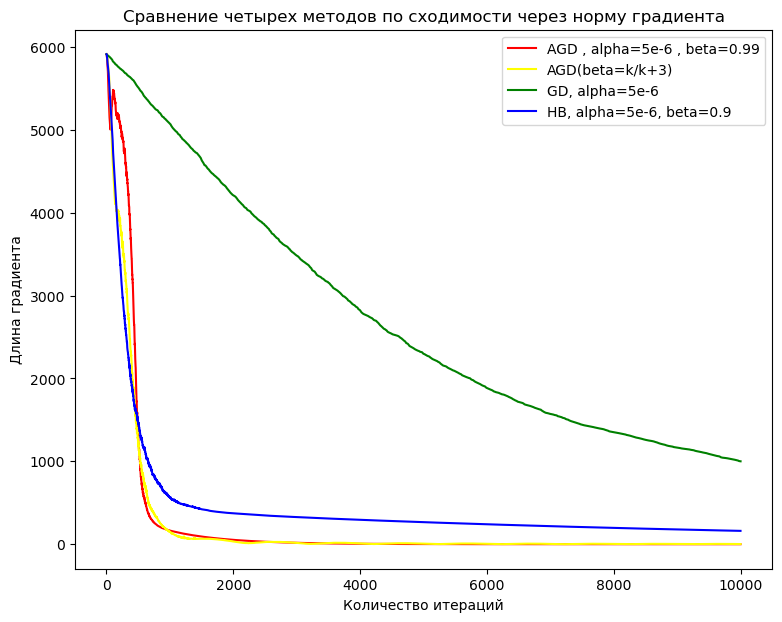

In [15]:
plt.figure(figsize=(9, 7))
plt.plot(agd_grad_history , color = 'Red')
plt.plot(magd_grad_history , color = 'Yellow')
plt.plot([np.linalg.norm(grad(i)) for i in x1_conv_gd ] , color = 'Green' )
plt.plot(hb_grad_history , color = 'Blue')
plt.legend(["AGD , alpha=5e-6 , beta=0.99","AGD(beta=k/k+3)","GD, alpha=5e-6","HB, alpha=5e-6, beta=0.9"])
plt.title('Сравнение четырех методов по сходимости через норму градиента')
plt.ylabel('Длина градиента')
plt.xlabel('Количество итераций')

Text(0.5, 0, 'Количество итераций')

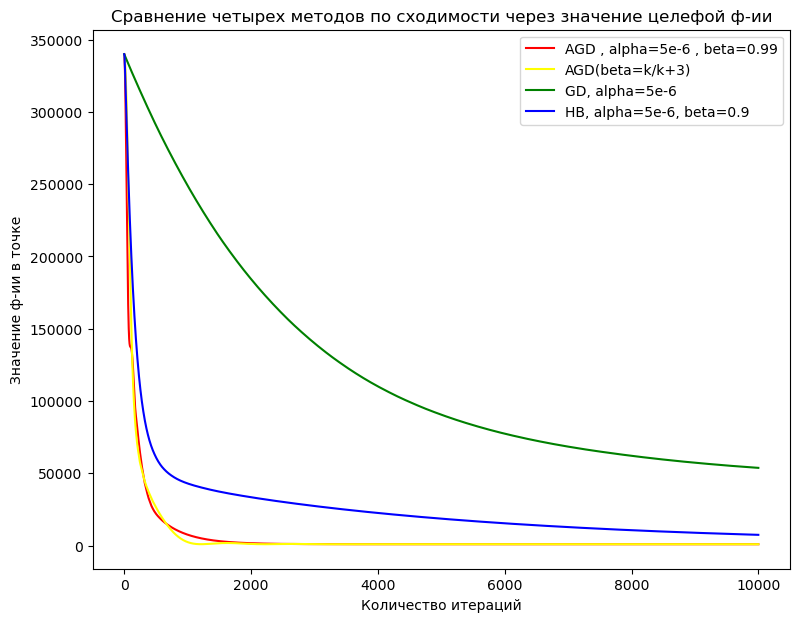

In [16]:
plt.figure(figsize=(9, 7))
plt.plot([f(x) for x in agd_history] , color = 'Red')
plt.plot([f(x) for x in magd_history] , color = 'Yellow')
plt.plot([f(x) for x in x1_conv_gd ] , color = 'Green' )
plt.plot([f(x) for x in hb_history] , color = 'Blue')
plt.legend(["AGD , alpha=5e-6 , beta=0.99","AGD(beta=k/k+3)","GD, alpha=5e-6","HB, alpha=5e-6, beta=0.9"])
plt.title('Сравнение четырех методов по сходимости через значение целефой ф-ии')
plt.ylabel('Значение ф-ии в точке')
plt.xlabel('Количество итераций')

# Вывод :
    На этой же задаче алгоритмы AGD и HB показали значимый прирост в скорости сходимости по сравнению с GD.
    
    HB(alpha=0.000005,beta=0.9)  значительно перегоняет GD в скорости сходимости .
    
    AGD(alpha=0.000005,beta=0.99) в самом начале пути чуть чуть запнулся и уступил HB в скорости 
    сходимости(по норме градиента) , однако потом всё равно ускорился и перегнал HB(и тем более GD)
    
    ModifiedAGD примерно сравним с AGD(beta=const)
    
    ModifiedAGD, AGD и HB потребовалость примерно 2к итераций для выхода на плато по норме градиента , 
    в то время как GD даже на 10к итерациях еще и близко не догонял их . 
    Увеличивать кол-во итераций я не стал , так как 10к достаточно что бы сделать выводы о 
    качестве алгоритмов и их конкурентных преимуществах по сравнению с GD.

Text(0.5, 1.0, 'Решение четырех алгоритмов')

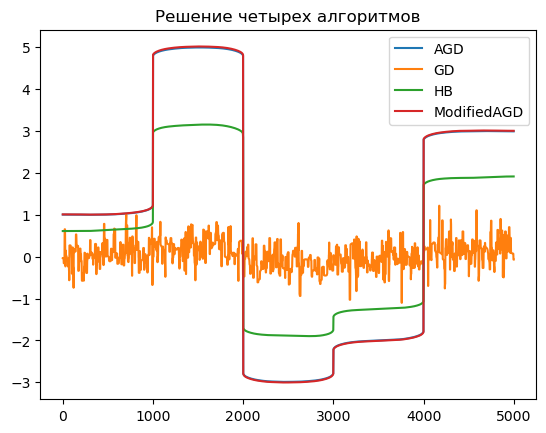

In [17]:
plt.plot(agd)
plt.plot(x1_gd)
plt.plot(hb)
plt.plot(magd)
plt.legend(["AGD","GD","HB" , "ModifiedAGD"])
plt.title('Решение четырех алгоритмов')

# Анализ влияня параметров в моделях

### Анализ влияния величины alpha в HB

In [18]:
alpha1 , alpha2 , alpha3 , alpha4 = 0.0005 , 0.00005 , 0.000005 , 0.0000005
beta  = 0.99
maxiter = 10000
hb1 , hb_history1 , hb_grad_history1 = heavy_ball(grad , x0, maxiter, tol, alpha1 ,beta)
hb2 , hb_history2 , hb_grad_history2 = heavy_ball(grad , x0, maxiter, tol, alpha2 ,beta)
hb3 , hb_history3 , hb_grad_history3 = heavy_ball(grad , x0, maxiter, tol, alpha3 ,beta)
hb4 , hb_history4 , hb_grad_history4 = heavy_ball(grad , x0, maxiter, tol, alpha4 ,beta)

Text(0.5, 0, 'Количество итераций')

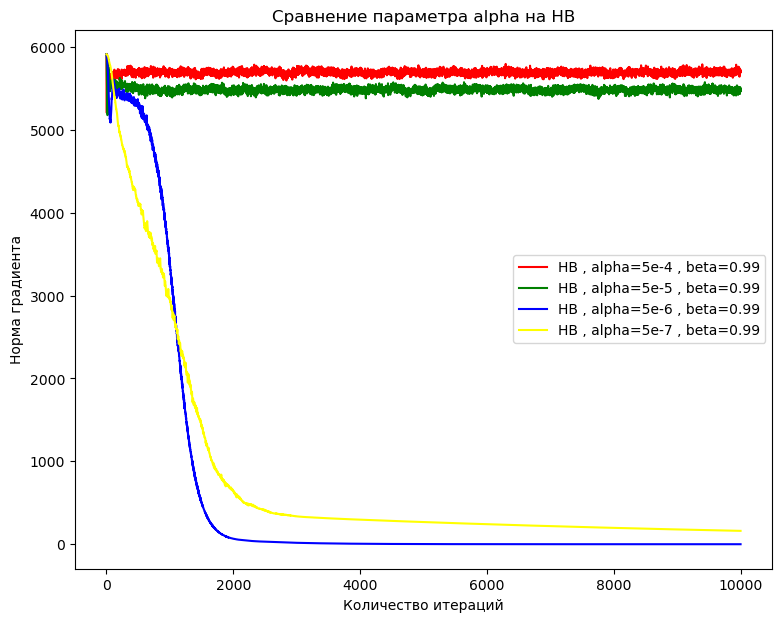

In [19]:
plt.figure(figsize=(9, 7))
plt.plot(hb_grad_history1 , color = 'Red')
plt.plot(hb_grad_history2 , color = 'Green' )
plt.plot(hb_grad_history3 , color = 'Blue')
plt.plot(hb_grad_history4 , color = 'Yellow')
plt.legend(["HB , alpha=5e-4 , beta=0.99","HB , alpha=5e-5 , beta=0.99","HB , alpha=5e-6 , beta=0.99","HB , alpha=5e-7 , beta=0.99"])
plt.title('Сравнение параметра alpha на HB')
plt.ylabel('Норма градиента')
plt.xlabel('Количество итераций')

# Вывод : 
    alpha = 5e-6 оказался наилучшим параметром . При мЕньших alpha алгорим не сходится , 
    при бОльшей - сходится, но медленно

### Анализ влияния величины beta в HB

In [20]:
alpha = 0.000005
beta1 , beta2 , beta3 , beta4  = 0.7 , 0.9 , 0.99 , 1
maxiter = 10000
hb1 , hb_history1 , hb_grad_history1 = heavy_ball(grad , x0, maxiter, tol, alpha ,beta1)
hb2 , hb_history2 , hb_grad_history2 = heavy_ball(grad , x0, maxiter, tol, alpha ,beta2)
hb3 , hb_history3 , hb_grad_history3 = heavy_ball(grad , x0, maxiter, tol, alpha ,beta3)
hb4 , hb_history4 , hb_grad_history4 = heavy_ball(grad , x0, maxiter, tol, alpha ,beta4)

Text(0.5, 0, 'Количество итераций')

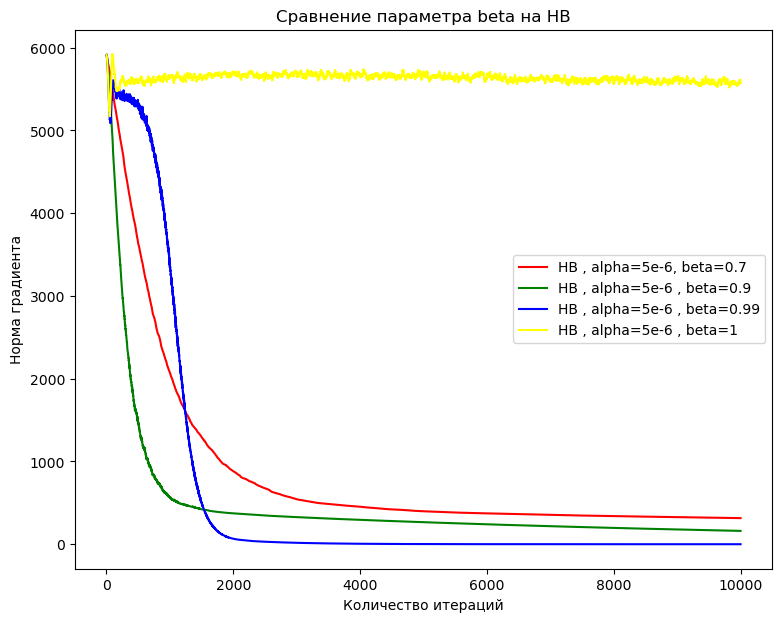

In [21]:
plt.figure(figsize=(9, 7))
plt.plot(hb_grad_history1 , color = 'Red')
plt.plot(hb_grad_history2 , color = 'Green' )
plt.plot(hb_grad_history3 , color = 'Blue')
plt.plot(hb_grad_history4 , color = 'Yellow')
plt.legend(["HB , alpha=5e-6, beta=0.7","HB , alpha=5e-6 , beta=0.9","HB , alpha=5e-6 , beta=0.99","HB , alpha=5e-6 , beta=1"])
plt.title('Сравнение параметра beta на HB')
plt.ylabel('Норма градиента')
plt.xlabel('Количество итераций')

# Вывод : 
    beta = 0.99 оказался наилучшим параметром . Несмотря на то , что в начале он отстаёт от остальных , 
    примерно на двухтысячной итерации алгоритм с этой бетой начинает всех обгонять по размеру нормы градиента
    
    Итого AGD(a=5e-6 , b=0.99) оказывается наилучшим алгоритмом который удалось собрать . 

### Анализ влияния величины alpha в AGD

In [22]:
alpha1 , alpha2 , alpha3 , alpha4 = 0.0005 , 0.00005 , 0.000005 , 0.0000005
beta  = 0.99
maxiter = 10000
agd1 , agd_history , agd_grad_history1 = AGD(grad , x0, maxiter,  alpha1 ,beta)
agd2 , agd_history , agd_grad_history2 = AGD(grad , x0, maxiter,  alpha2 ,beta)
agd3 , agd_history , agd_grad_history3 = AGD(grad , x0, maxiter,  alpha3 ,beta)
agd4 , agd_history , agd_grad_history4 = AGD(grad , x0, maxiter,  alpha4 ,beta)

Text(0.5, 0, 'Количество итераций')

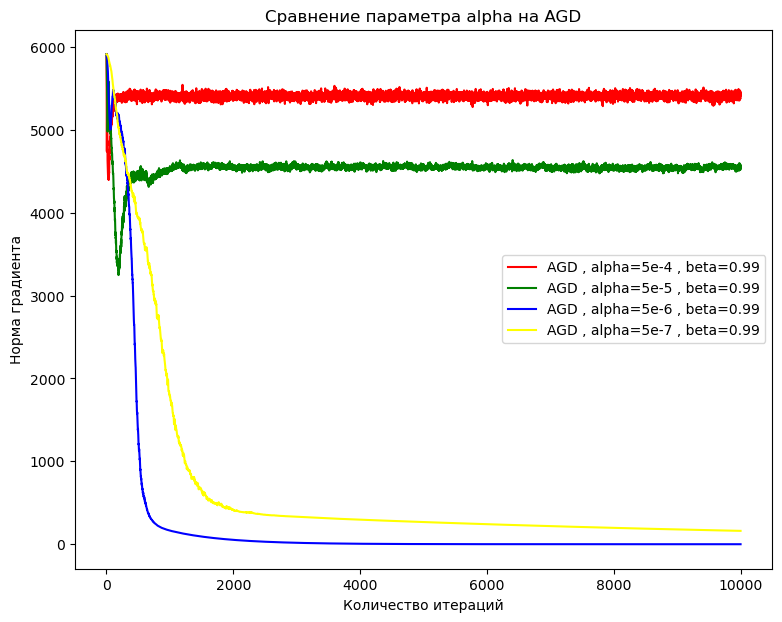

In [23]:
plt.figure(figsize=(9, 7))
plt.plot(agd_grad_history1 , color = 'Red')
plt.plot(agd_grad_history2 , color = 'Green' )
plt.plot(agd_grad_history3 , color = 'Blue')
plt.plot(agd_grad_history4 , color = 'Yellow')
plt.legend(["AGD , alpha=5e-4 , beta=0.99","AGD , alpha=5e-5 , beta=0.99","AGD , alpha=5e-6 , beta=0.99","AGD , alpha=5e-7 , beta=0.99"])
plt.title('Сравнение параметра alpha на AGD')
plt.ylabel('Норма градиента')
plt.xlabel('Количество итераций')

# Вывод :
    Параметр alpha = 5e-6 оказался наилучшим . Именно на нем достигается наилучшая сходимость.
    

### Анализ влияния величины beta в AGD

In [24]:
alpha = 0.000005
beta1 , beta2 , beta3 , beta4  = 0.7 , 0.9 , 0.99 , 1
maxiter = 10000
agd1 , agd_history , agd_grad_history1 = AGD(grad , x0, maxiter,  alpha ,beta1)
agd1 , agd_history , agd_grad_history2 = AGD(grad , x0, maxiter,  alpha ,beta2)
agd1 , agd_history , agd_grad_history3 = AGD(grad , x0, maxiter,  alpha ,beta3)
agd1 , agd_history , agd_grad_history4 = AGD(grad , x0, maxiter,  alpha ,beta4)

Text(0.5, 0, 'Количество итераций')

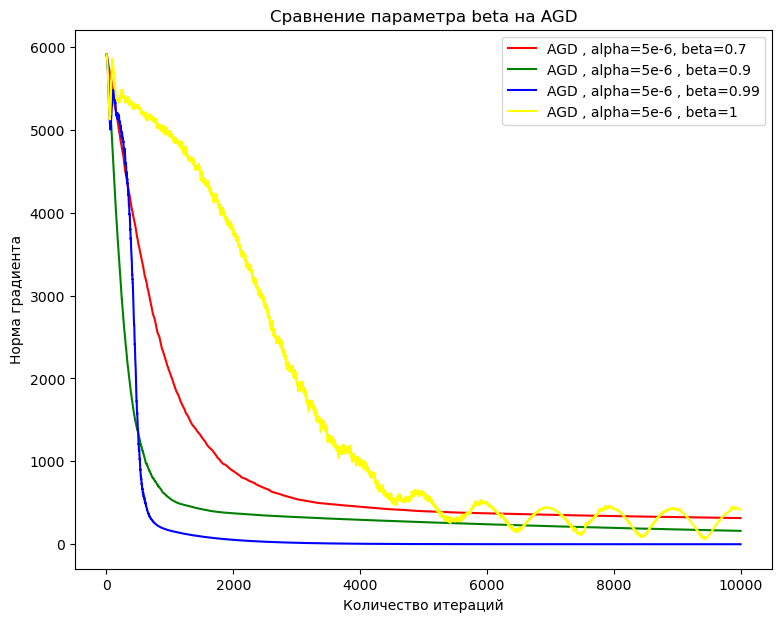

In [25]:
plt.figure(figsize=(9, 7))
plt.plot(agd_grad_history1 , color = 'Red')
plt.plot(agd_grad_history2 , color = 'Green' )
plt.plot(agd_grad_history3 , color = 'Blue')
plt.plot(agd_grad_history4 , color = 'Yellow')
plt.legend(["AGD , alpha=5e-6, beta=0.7","AGD , alpha=5e-6 , beta=0.9","AGD , alpha=5e-6 , beta=0.99","AGD , alpha=5e-6 , beta=1"])
plt.title('Сравнение параметра beta на AGD')
plt.ylabel('Норма градиента')
plt.xlabel('Количество итераций')

# Вывод :
    Параметр beta=0.99 оказался наилучшим с точки зрения сходиомсти . Несмотря на то , что в самом начале его
    перегоняли алгоритмы с другими параметрами , он все равно сходится наиболее точно чем они .
    
    Итого наилучшая комбинация параметров для AGD которую удалось найти это alpha=5e-6 , beta = 0.99
    

# Общий вывод по всем моделям и всем параметрам
    Все модели оказались сильно чувствительными к параметру альфа , при чем настолько , что при 
    переходе с 0.000005 на 0.00005 качество моделей крайне сильно падало и они начинали расходиться.
    К параметру beta модели HB и  AGD тоже оказались довольно чувствительны, оптимальное значение данного 
    параметра удалось найти равным 0.99